<a href="https://colab.research.google.com/github/xinyanz-erin/Applied-Finance-Project/blob/Erin/Barrier_Call_jax_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl https://colab.chainer.org/install |sh -
import cupy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1580  100  1580    0     0   9186      0 --:--:-- --:--:-- --:--:--  9186
+ apt -y -q install cuda-libraries-dev-10-0
Reading package lists...
Building dependency tree...
Reading state information...
cuda-libraries-dev-10-0 is already the newest version (10.0.130-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
+ pip install -q cupy-cuda100  chainer 
+ set +ex
Installation succeeded!


# Test (Skip this if not trying to test, to make sure that functions are defined correctly in cells below without running this cell)

## Knock out call

In [2]:
# # Knock out call

# # now change code such that 'numsteps' does not represent year
# # make dt = year / numsteps
# # Add r, and notice that noise must have mean 0, not drift, or else it'll give large option prices
# # (done)
# # after making the changes, the values are still correct

# import jax
# import jax.numpy as jnp
# from jax import random
# from jax import jit
# import numpy as np
# from torch.utils.dlpack import from_dlpack

# def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
#     stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
#     stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
#                             jax.ops.index[0],         # initialization of stock prices
#                             initial_stocks)
#     noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
#     sigma = jnp.diag(cov) ** 0.5
#     dt = T / numsteps
#     def time_step(t, val):
#         #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
#         dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
#         val = jax.ops.index_update(val,
#                             jax.ops.index[t],
#                             val[t-1] * dx2)
#         return val
#     return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

# def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T): # down-and-out call
#     # print(batch_simple(keys, initial_stocks, numsteps, drift, cov, T))
#     # print(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))
#     # print((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int)))
#     return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
#                                 (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
#                     jnp.exp(-r[0] * T))
#     # must use '-1' not 'numsteps', or else grad will be 0

# numstocks = 3

# rng = jax.random.PRNGKey(1)
# rng, key = jax.random.split(rng)
# numsteps = 50
# drift = jnp.array([0.]*numstocks)
# r = drift # let r = drift to match B-S

# cov = jnp.identity(numstocks)*0.5*0.5
# initial_stocks = jnp.array([100.]*numstocks) # must be float

# T = 1.0
# K = 60.0
# B = 78.4 # if B is set to 0, equivalent to European call

# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# #fast_simple(key, initial_stocks, numsteps, drift, cov)

# keys = jax.random.split(key, 100000)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# # print(initial_stocks) #S
# # print(K) #K
# # print(B) #B
# # print(cov) #sigma
# # print(drift) #drift

# # option price
# # 3 stocks basket
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

# # delta
# # 3 stock basket
# goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T)) # here numsteps different from T

## Knock in call

In [6]:
# Knock in call
# B>K
# Once price reaches B, get immediate payoff (S[knock-in]-K)
# change r to an array of length 'numsteps'

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # down-and-out call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    knock_out_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)

    count_matrix = np.repeat([np.arange(numsteps)], numpaths, axis=0) # matrix [[0,1,2,...],[0,1,2,...],...]
    bool_matrix = count_matrix <= knock_out_index[:,None] # matrix: 1: index <= knock_out_index for each row, else 0
    r_matrix = jnp.tile(r, (numpaths, 1)) * bool_matrix.astype(int) # repeat r array 'numpaths' times as a matrix, then multiply by bool_matrix
    masked = np.ma.masked_equal(r_matrix, 0) # mask so that 0 becomes invalid (for computing mean later)
    r_mean_array = masked.mean(axis=1)

    # print(out)
    # print(jnp.mean(out, axis=2))
    # print(jnp.all(jnp.mean(out, axis=2) < B, axis=1))
    # print(knock_out_index)
    # print((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *
    #       (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K))    # (1 or 0) * (S[knock-in]-K)
    # print(count_matrix)
    # print(bool_matrix)
    # print(r_matrix)
    # print(masked)
    # print(r_mean_array)

############################# This method is slow
    # print(jnp.nan_to_num(jnp.array([r_matrix[i,:(index+1)].mean() for i,index in enumerate(knock_out_index)])))
    # print(T * (knock_out_index+1) / numsteps)
    # print((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
    #                 (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
    #                 jnp.exp(-jnp.nan_to_num(jnp.array([r_matrix[i,:(index+1)].mean() for i,index in enumerate(knock_out_index)])) * (T * (knock_out_index+1) / numsteps)))

    # return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
    #                 (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
    #                 jnp.exp(-jnp.nan_to_num(jnp.array([r_matrix[i,:(index+1)].mean() for i,index in enumerate(knock_out_index)])) * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))
#############################

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))

# numstocks = 3

# # np.random.seed(1)
# rng = jax.random.PRNGKey(np.random.randint(10000))
# rng, key = jax.random.split(rng)
# # numsteps = 100
# # numpaths = 200
# drift = jnp.array([0.]*numstocks)
# r = jnp.array(np.random.random(numsteps) * 0.1) # r is an array now

# cov = jnp.identity(numstocks)*0.5*0.5
# initial_stocks = jnp.array([100.]*numstocks) # must be float

# T = 1.0
# K = 100.0
# B = 120.0

# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# #fast_simple(key, initial_stocks, numsteps, drift, cov)

# keys = jax.random.split(key, numpaths)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# print('initial price is')
# print(initial_stocks) #S
# print('\n K is \n' + str(K)) #K
# print('\n B is \n' + str(B)) #B
# print('\n cov is \n' + str(cov)) #sigma
# print('\n drift is \n' + str(drift)) #drift
# print('\n r is \n' + str(r) + '\n') #r
 

# import time
# start = time.process_time()
# # option price
# # 3 stocks basket
# print(f'{str(numstocks)} stocks\' basket knock-in option price is')
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
# print('\n Time:' + str(time.process_time() - start))


# start = time.process_time()
# delta
# 3 stock basket
# goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
# print(time.process_time() - start)

In [13]:
Paths = np.array([100, 1e3, 1e4, 1e5], dtype=int)
Steps = np.array([50, 100, 200, 500], dtype=int)

origi = np.zeros((len(Paths), len(Steps)))

for i in range(len(Paths)):
  numpaths = Paths[i]
  for j in range(len(Steps)):
    numsteps = Steps[j]
    numstocks = 3
    # np.random.seed(1)
    rng = jax.random.PRNGKey(np.random.randint(10000))
    rng, key = jax.random.split(rng)
    drift = jnp.array([0.]*numstocks)
    r = jnp.array(np.random.random(numsteps) * 0.1) # r is an array now
    # r = jnp.array([0.1] * numsteps)
    cov = jnp.identity(numstocks)*0.5*0.5
    initial_stocks = jnp.array([100.]*numstocks) # must be float

    T = 1.0
    K = 100.0
    B = 120.0

    fast_simple = jax.jit(Brownian_motion, static_argnums=2)
    #fast_simple(key, initial_stocks, numsteps, drift, cov)

    keys = jax.random.split(key, numpaths/2)
    batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

    time = %timeit -o optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)
    origi[i, j] = time.best


100 loops, best of 5: 12.8 ms per loop
100 loops, best of 5: 13.7 ms per loop
100 loops, best of 5: 15.4 ms per loop
10 loops, best of 5: 20.4 ms per loop
100 loops, best of 5: 13.7 ms per loop
100 loops, best of 5: 15.1 ms per loop
100 loops, best of 5: 18.1 ms per loop
10 loops, best of 5: 27.5 ms per loop
10 loops, best of 5: 20.7 ms per loop
10 loops, best of 5: 28.4 ms per loop
10 loops, best of 5: 46 ms per loop
10 loops, best of 5: 95 ms per loop
10 loops, best of 5: 94.5 ms per loop
10 loops, best of 5: 171 ms per loop
1 loop, best of 5: 317 ms per loop
1 loop, best of 5: 774 ms per loop


In [14]:
origi

array([[0.01282893, 0.01367488, 0.01541089, 0.02043614],
       [0.01367616, 0.01511317, 0.01812832, 0.02747995],
       [0.02068289, 0.02837201, 0.04604835, 0.09496131],
       [0.09448499, 0.17067462, 0.31703227, 0.77396607]])

## Antithetic

In [9]:
# Knock in call
# B>K
# Once price reaches B, get immediate payoff (S[knock-in]-K)
# change r to an array of length 'numsteps'

import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    noise = jnp.hstack((noise, -noise))
    # noise = jnp.hstack((noise, jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,))))
    sigma = jnp.repeat(jnp.diag(cov) ** 0.5,2)
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx = jnp.exp((jnp.repeat(drift,2) - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx)
        # val = jax.ops.index_update(val, jax.ops.index[t], noise[t,:])
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, jnp.hstack((stocks_init, stocks_init)))[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths): # down-and-out call
    out = batch_simple(keys, initial_stocks, numsteps, drift, cov, T)
    # print(out)
    # out = jnp.reshape(out, (numpaths, numsteps, numstocks))

    out1 = out[:,:,0:numstocks]
    out2 = out[:,:,numstocks:]

    out = jnp.append(out1, out2, axis = 0)

    # print(out)
    knock_out_index = jnp.argmax(jnp.mean(out, axis=2) >= B, axis=1)
    count_matrix = np.repeat([np.arange(numsteps)], numpaths, axis=0) # matrix [[0,1,2,...],[0,1,2,...],...]
    bool_matrix = count_matrix <= knock_out_index[:,None] # matrix: 1: index <= knock_out_index for each row, else 0
    r_matrix = jnp.tile(r, (numpaths, 1)) * bool_matrix.astype(int) # repeat r array 'numpaths' times as a matrix, then multiply by bool_matrix
    masked = np.ma.masked_equal(r_matrix, 0) # mask so that 0 becomes invalid (for computing mean later)
    r_mean_array = masked.mean(axis=1)

    return jnp.mean((1 - jnp.all(jnp.mean(out, axis=2) < B, axis=1).astype(int)) *  # knock in: 1, else: 0
                    (jnp.mean(out, axis=2)[jnp.arange(numpaths), knock_out_index] - K) *   # (S[knock-in]-K)
                    jnp.exp(- r_mean_array * (T * (knock_out_index+1) / numsteps))) # (exp(-mean(r until payoff) * (t until payoff)))
    # return out


# numstocks = 3
# # np.random.seed(1)
# rng = jax.random.PRNGKey(np.random.randint(10000))
# rng, key = jax.random.split(rng)
# # numsteps = 50
# # numpaths = 100
# drift = jnp.array([0.]*numstocks)
# r = jnp.array(np.random.random(numsteps) * 0.1) # r is an array now
# # r = jnp.array([0.1] * numsteps)
# cov = jnp.identity(numstocks)*0.5*0.5
# initial_stocks = jnp.array([100.]*numstocks) # must be float

# T = 1.0
# K = 100.0
# B = 120.0

# fast_simple = jax.jit(Brownian_motion, static_argnums=2)
# #fast_simple(key, initial_stocks, numsteps, drift, cov)

# keys = jax.random.split(key, numpaths/2)
# batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

# print('initial price is')
# print(initial_stocks) #S
# print('\n K is \n' + str(K)) #K
# print('\n B is \n' + str(B)) #B
# print('\n cov is \n' + str(cov)) #sigma
# print('\n drift is \n' + str(drift)) #drift
# # print('\n r is \n' + str(r) + '\n') #r
 

# import time
# start = time.process_time()
# option price
# 3 stocks basket
# print(f'{str(numstocks)} stocks\' basket knock-in option price is')
# print(optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
# print('\n Time:' + str(time.process_time() - start))
# test = optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)


# start = time.process_time()
### delta
### 3 stock basket
# goptionvalueavg = jax.grad(optionvalueavg,argnums=1)
# print(goptionvalueavg(keys, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)) # here numsteps different from T
# print(time.process_time() - start)

# import timeit
# timeit.timeit(optionvalueavg())

In [10]:
# time = %timeit -o optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)
# time.best

In [11]:
Paths = np.array([100, 1e3, 1e4, 1e5], dtype=int)
Steps = np.array([50, 100, 200, 500], dtype=int)

anti = np.zeros((len(Paths), len(Steps)))

for i in range(len(Paths)):
  numpaths = Paths[i]
  for j in range(len(Steps)):
    numsteps = Steps[j]
    numstocks = 3
    # np.random.seed(1)
    rng = jax.random.PRNGKey(np.random.randint(10000))
    rng, key = jax.random.split(rng)
    drift = jnp.array([0.]*numstocks)
    r = jnp.array(np.random.random(numsteps) * 0.1) # r is an array now
    # r = jnp.array([0.1] * numsteps)
    cov = jnp.identity(numstocks)*0.5*0.5
    initial_stocks = jnp.array([100.]*numstocks) # must be float

    T = 1.0
    K = 100.0
    B = 120.0

    fast_simple = jax.jit(Brownian_motion, static_argnums=2)
    #fast_simple(key, initial_stocks, numsteps, drift, cov)

    keys = jax.random.split(key, numpaths/2)
    batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))

    time = %timeit -o optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, numpaths)
    anti[i, j] = time.best


The slowest run took 182.49 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 12.9 ms per loop
The slowest run took 97.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 13.9 ms per loop
The slowest run took 84.22 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 16 ms per loop
The slowest run took 67.30 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 20.3 ms per loop
The slowest run took 149.47 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 13.4 ms per loop
The slowest run took 76.45 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 15.7 ms per loop
The slowest run took 67.89 times longer than the fastest. This could m

In [12]:
anti

array([[0.01290225, 0.01393548, 0.01604415, 0.02029117],
       [0.01341648, 0.015749  , 0.01775598, 0.02658779],
       [0.02140843, 0.02967289, 0.04651724, 0.09111416],
       [0.09133967, 0.16042385, 0.30883002, 0.74894473]])

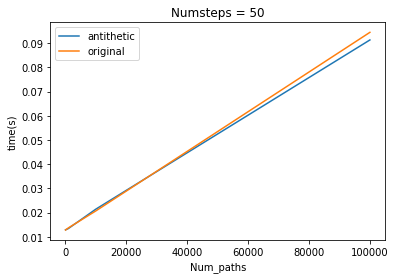

In [18]:
import matplotlib.pyplot as plt

plt.plot(Paths, anti[:,0], label = 'antithetic')
plt.plot(Paths, origi[:,0], label = 'original')
plt.legend()
plt.xlabel('Num_paths')
plt.ylabel('time(s)')
plt.title('Numsteps = 50')
plt.show()

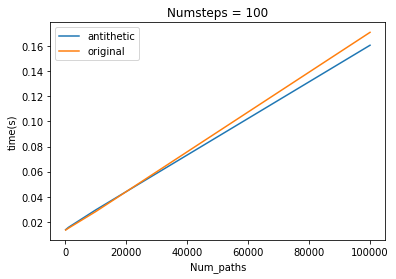

In [20]:
plt.plot(Paths, anti[:,1], label = 'antithetic')
plt.plot(Paths, origi[:,1], label = 'original')
plt.legend()
plt.xlabel('Num_paths')
plt.ylabel('time(s)')
plt.title('Numsteps = 100')
plt.show()

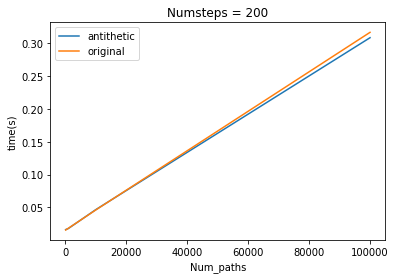

In [21]:
plt.plot(Paths, anti[:,2], label = 'antithetic')
plt.plot(Paths, origi[:,2], label = 'original')
plt.legend()
plt.xlabel('Num_paths')
plt.ylabel('time(s)')
plt.title('Numsteps = 200')
plt.show()

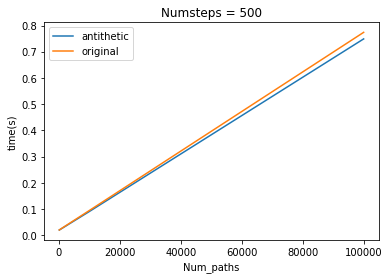

In [22]:
plt.plot(Paths, anti[:,3], label = 'antithetic')
plt.plot(Paths, origi[:,3], label = 'original')
plt.legend()
plt.xlabel('Num_paths')
plt.ylabel('time(s)')
plt.title('Numsteps = 500')
plt.show()

# Construct Neural Net

In [ ]:
%%writefile cupy_dataset.py
import cupy
import jax
import jax.numpy as jnp
from jax import random
from jax import jit
import numpy as np
from torch.utils.dlpack import from_dlpack

def Brownian_motion(key, initial_stocks, numsteps, drift, cov, T):
    stocks_init = jnp.zeros((numsteps + 1, initial_stocks.shape[0]))
    stocks_init = jax.ops.index_update(stocks_init,   # jax.ops.index_update(x, idx, y) <-> Pure equivalent of x[idx] = y
                            jax.ops.index[0],         # initialization of stock prices
                            initial_stocks)
    noise = jax.random.multivariate_normal(key,  jnp.array([0]*initial_stocks.shape[0]), cov, (numsteps+1,)) # noise must have mean 0
    sigma = jnp.diag(cov) ** 0.5
    dt = T / numsteps
    def time_step(t, val):
        #dx =  drift + noise[t,:] # no need to multiply by sigma here because noise generated by cov not corr
        dx2 = jnp.exp((drift - sigma ** 2. / 2.) * dt + jnp.sqrt(dt) * noise[t,:])
        val = jax.ops.index_update(val,
                            jax.ops.index[t],
                            val[t-1] * dx2)
        return val
    return jax.lax.fori_loop(1, numsteps+1, time_step, stocks_init)[1:] # jax.lax.fori_loop(lower, upper, body_fun, init_val)

def optionvalueavg(key, initial_stocks, numsteps, drift, r, cov, K, B, T, keys): # down-and-out call
    return jnp.mean(jnp.maximum((1 - jnp.any(jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2) < B, axis=1).astype(int))* 
                                (jnp.mean(batch_simple(keys, initial_stocks, numsteps, drift, cov, T), axis=2))[:,-1]-K, 0) *
                    jnp.exp(-r[0] * T))
    # must use '-1' not 'numsteps', or else grad will be 0

###################################################################################################
# these 2 functions must be defined outside class in order to be used in 'optionvalueavg' function
fast_simple = jax.jit(Brownian_motion, static_argnums=2)
batch_simple = jax.vmap(fast_simple, in_axes=(0, None, None, None, None, None))
###################################################################################################

class OptionDataSet(object):
    
    def __init__(self, max_len, number_path, batch, seed, stocks):
        self.num = 0
        self.max_length = max_len
        self.N_PATHS = number_path
        self.N_STEPS = 50
        self.N_BATCH = batch
        self.N_STOCKS = stocks
        self.T = 1.0 # assume T = 1, use float here
        self.seed = seed
        np.random.seed(seed)
        
    def __len__(self):
        return self.max_length
        
    def __iter__(self):
        self.num = 0
        return self
    
    def __next__(self):
        if self.num >= self.max_length:
            raise StopIteration
        
        Y = cupy.zeros((self.N_BATCH, 1 + self.N_STOCKS), dtype=cupy.float32) # output: price, delta1, delta2, delta3
        X = cupy.zeros((self.N_BATCH, self.N_STOCKS * 7), dtype = cupy.float32)

        for op in range(self.N_BATCH):
          
          rng = jax.random.PRNGKey(self.seed)
          rng, key = jax.random.split(rng)

          ################################################################################################### generate random input numbers

          initial_stocks = jnp.array(np.random.random(self.N_STOCKS) * 200.0)

          corr = jnp.diag(jnp.array([1]*self.N_STOCKS)) # assume no correlation between stocks here
          sigma = jnp.array(np.random.random(self.N_STOCKS) * 0.4)
          cov = (jnp.diag(sigma)).dot(corr).dot(jnp.diag(sigma))

          r = jnp.repeat(jnp.array(np.random.random(1) * 0.1), self.N_STOCKS)
          drift = r # To match BS, use drift = r

          T = self.T
          K = np.random.random(1) * 200.0
          B = np.random.random(1) * 200.0 * 0.6 # B can't be too large

          ###################################################################################################
          ################################################################################################### apply functions to compute price and deltas
          
          keys = jax.random.split(key, self.N_PATHS)

          European_Call_price = optionvalueavg(key, initial_stocks, self.N_STEPS, drift, r, cov, K, B, T, keys) # need to pass 'keys'
          gooptionvalue = jax.grad(optionvalueavg, argnums=1)
          Deltas = gooptionvalue(keys, initial_stocks, self.N_STEPS, drift, r, cov, K, B, T, keys) # need to pass 'keys'

          ###################################################################################################
          ################################################################################################### store input and output numbers in X and Y

          Y[op, 0] = European_Call_price
          Y[op, 1:4] = cupy.array(Deltas, dtype=cupy.float32)

          # T, B, K, S, sigma, mu, r
          paras = (jnp.repeat(jnp.array(T), self.N_STOCKS), jnp.repeat(jnp.array(B), self.N_STOCKS), jnp.repeat(jnp.array(K), self.N_STOCKS), initial_stocks, sigma, drift, r)
          paras = np.column_stack(paras).reshape(1,-1)[0]
          X[op,] = cupy.array(paras)

          ###################################################################################################

        self.num += 1
        return (from_dlpack(X.toDlpack()), from_dlpack(Y.toDlpack()))


# ds = OptionDataSet(max_len = 2, number_path = 10000, batch = 2, seed = 15, stocks=3) # for testing purpose, use constant seed. When training, change to random seed
# for i in ds:
#     print(i)

In [ ]:
%%writefile model.py
import torch.nn as nn
import torch.nn.functional as F
import torch
import numpy as np

class Net(nn.Module):

    def __init__(self, hidden=1024):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(7*3, hidden) # remember to change this!
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, hidden)
        self.fc4 = nn.Linear(hidden, hidden)
        self.fc5 = nn.Linear(hidden, hidden)
        self.fc6 = nn.Linear(hidden, 4) # 4 outputs: price, delta1, delta2, delta3
        self.register_buffer('norm',
                             torch.tensor([1, 200.0*0.6, 200.0, 200.0, 0.4, 0.1, 0.1]*3)) # don't use numpy here - will give error later
                             # T, B, K, S, sigma, mu, r

    def forward(self, x):
        # normalize the parameter to range [0-1] 
        x = x / self.norm
        x = F.elu(self.fc1(x))
        x = F.elu(self.fc2(x))
        x = F.elu(self.fc3(x))
        x = F.elu(self.fc4(x))
        x = F.elu(self.fc5(x))
        return self.fc6(x)

# Train Neural Net

In [ ]:
!pip install pytorch-ignite

In [ ]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 3) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 100)

**Save Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
model_save_name = 'jax_barrier_test_1.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

**Load Model**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import torch
model_save_name = 'Sobolev_test_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
state_dict = torch.load(path)
print(state_dict.keys())

In [ ]:
# need to run 'Writing cupy_dataset.py' and 'Writing model.py' above before this
from model import Net
model = Net().cuda()

model.load_state_dict(state_dict)
print(model)

**Continue to train model**

In [ ]:
# If memory is not enough, try changing parameters and restarting session
# loss will converge

from ignite.engine import Engine, Events
from ignite.handlers import Timer
from torch.nn import MSELoss
from torch.optim import Adam
from ignite.contrib.handlers.param_scheduler import CosineAnnealingScheduler
from ignite.handlers import ModelCheckpoint
from model import Net
from cupy_dataset import OptionDataSet
import numpy as np
timer = Timer(average=True)
#model = Net().cuda()
loss_fn = MSELoss()
optimizer = Adam(model.parameters(), lr=1e-3)
#dataset = OptionDataSet(max_len = 100, number_path = 1024, batch = 32, seed = np.random.randint(10000), stocks = 3) # must have random seed
dataset = OptionDataSet(max_len = 100, number_path = 10000, batch = 8, seed = np.random.randint(10000), stocks = 3) # must have random seed


def train_update(engine, batch):
    model.train()
    optimizer.zero_grad()
    x = batch[0]
    y = batch[1]
    #print(y)
    y_pred = model(x)
    #print(y_pred)
    loss = loss_fn(y_pred[:,:], y[:,:]) # compute MSE between the 2 arrays
    #print(loss)
    loss.backward()
    optimizer.step()
    return loss.item()

trainer = Engine(train_update)
log_interval = 20

scheduler = CosineAnnealingScheduler(optimizer, 'lr', 1e-4, 1e-6, len(dataset))
trainer.add_event_handler(Events.ITERATION_STARTED, scheduler)
timer.attach(trainer,
             start=Events.EPOCH_STARTED,
             resume=Events.ITERATION_STARTED,
             pause=Events.ITERATION_COMPLETED,
             step=Events.ITERATION_COMPLETED)    
@trainer.on(Events.ITERATION_COMPLETED)
def log_training_loss(engine):
    iter = (engine.state.iteration - 1) % len(dataset) + 1
    if iter % log_interval == 0:
        print('loss', engine.state.output, 'average time', timer.value(), 'iter num', iter)
        
trainer.run(dataset, max_epochs = 10)

model_save_name = 'jax_barrier_test_2.pth'
path = F"/content/drive/MyDrive/AFP Project/PUI/{model_save_name}" 
torch.save(model.state_dict(), path)

#Results

In [ ]:
import torch
inputs = torch.tensor([[1, 70, 110.0, 100.0, 0.25, 0., 0.]*3]).cuda()
model(inputs.float())